## Data analysis demo

This page is a demo analysis of a day of 7 train arrival times from June 1 2019, using data from the [MTA GTFS-RT archive](http://web.mta.info/developers/data/archives.html) processed using `gtfs_tripify`. **This tutorial will show you how to work with arrival logbooks**.

Although not required, it is helpful to have already skimmed the [Tutorial](https://residentmario.github.io/gtfs-tripify/tutorial.html), which demonstrates how logbooks are built. For the purposes of this demo we will use a dataset we prepared in advance.

In [1]:
import requests

import pandas as pd
pd.options.display.float_format = '{:.0f}'.format

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
import seaborn as sns

In [2]:
trains = pd.read_csv('https://raw.githubusercontent.com/ResidentMario/gtfs-tripify-demo-data/master/7_trains.csv')
trains.head()

,trip_id,route_id,action,minimum_time,maximum_time,stop_id,latest_information_time,stop_name,unique_trip_id
0,042200_7..N,7,STOPPED_OR_SKIPPED,1559386833,1559386852,726N,1559386852,34 St - 11 Av,24746f24-b4a2-11e9-9912-8c8590adc94b
1,042200_7..N,7,STOPPED_OR_SKIPPED,1559387014,1559387034,725N,1559387034,Times Sq - 42 St,24746f24-b4a2-11e9-9912-8c8590adc94b
2,042200_7..N,7,STOPPED_OR_SKIPPED,1559387124,1559387144,724N,1559387144,5 Av,24746f24-b4a2-11e9-9912-8c8590adc94b
3,042200_7..N,7,STOPPED_OR_SKIPPED,1559387214,1559387234,723N,1559387234,Grand Central - 42 St,24746f24-b4a2-11e9-9912-8c8590adc94b
4,042200_7..N,7,STOPPED_OR_SKIPPED,1559387394,1559387414,721N,1559387414,Vernon Blvd - Jackson Av,24746f24-b4a2-11e9-9912-8c8590adc94b


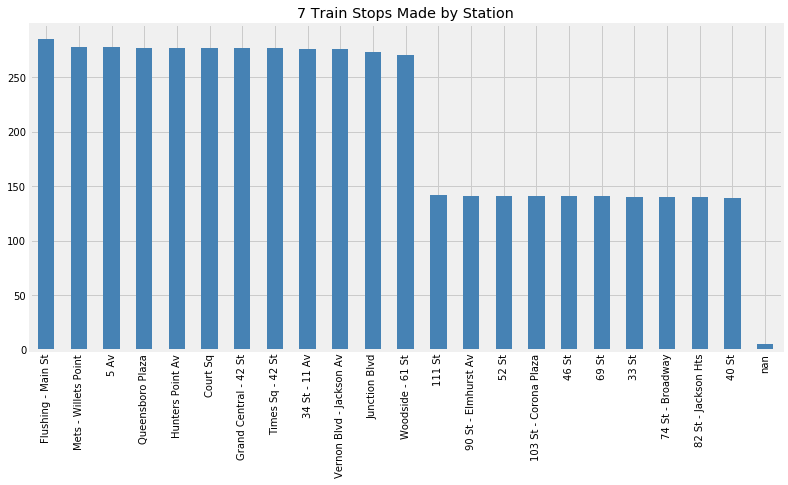

In [3]:
trains.stop_name.value_counts(dropna=False).sort_values(ascending=False).plot.bar(
    color='steelblue', figsize=(12, 6),
    title='7 Train Stops Made by Station'
)

The 7 train is split into a local service which makes all stops and an express service which makes an expedited set of stops during rush hours only. The rush hour trains skipped the second of stops in this dataset: 33 Street, 46 Street, and so on. Looking at this chart, we can see that there were around 275 or so total 7 train trips that day. About half of those trips ran as local trains and half ran as express trains.

The `nan` values here are for stop IDs with no corresponding stop name in the GTFS record. This seems like a data error on the MTA's part; maybe these stops are for the train yard?

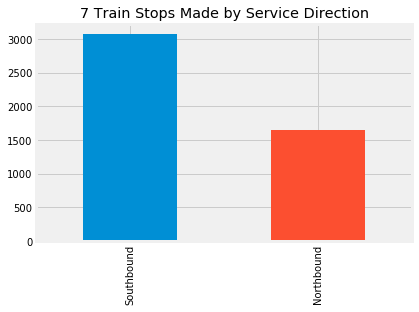

In [4]:
trains.stop_id.map(lambda stop_id: 'Northbound' if 'N' in stop_id else 'Southbound').value_counts().plot.bar(
    title='7 Train Stops Made by Service Direction'
)

The 7 train made over 3500 southbound stops that day, but only a touch over 2100 northbound ones. Even though the 7 train is primarily east-west, the MTA codes all of its train lines as north-west. In this case "north" means "west" (train trips starting in Flushing, Queens and ending at Hudson Yards in Manhattan) and "south" means "east" (train trips starting at Hudson Yards and ending in Flushing, Queens).

In [5]:
trains.groupby('unique_trip_id').route_id.head(1).value_counts()

7     332
7X      3
Name: route_id, dtype: int64

The `route_id` identifies the headsign a train is running under. Just three of the trains that ran that day were identified as `7X`, e.g. "7 express" trains. Most of the trains that ran the express service were identified as regular `7` trains in the data stream.

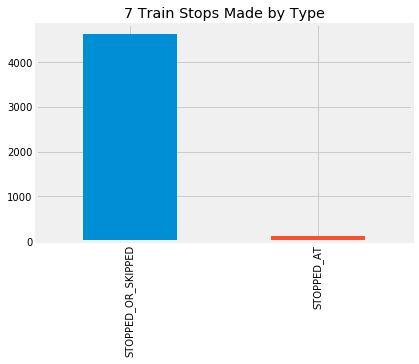

In [6]:
trains.action.value_counts().plot.bar(title='7 Train Stops Made by Type')

It may seem strange that this record contains only `STOPPED_OR_SKIPPED` records, which tell us that a train passed through a station, and no `STOPPED_AT` records, which tell us that a train stopped at a station for sure. However, this is just a consequence of how the MTA codes their systems. Messages about the 7 train always jump straight from "en route to this station" to "en route to the next station". It's almost completely safe to consider a `STOPPED_OR_SKIPPED` record as evidence that the train actually stopped at that station; a train skipping a scheduled stop can only occur due to operator error.

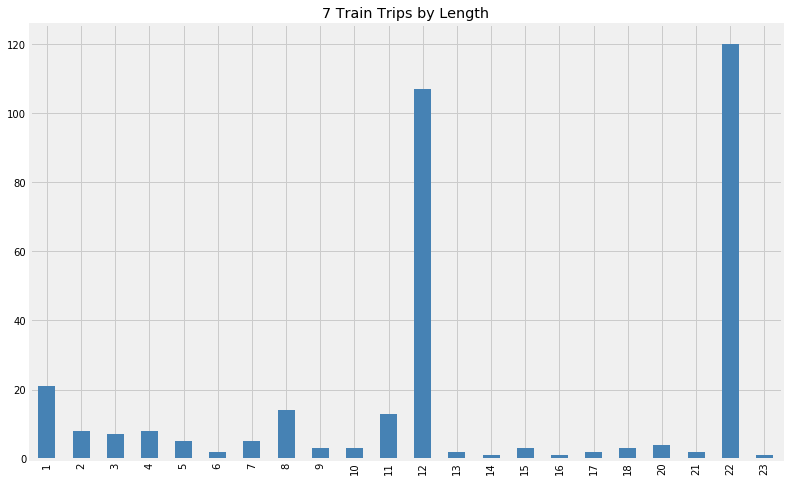

In [7]:
trains.assign(n=0).groupby('unique_trip_id').agg(len).n.value_counts().sort_index().plot.bar(
    figsize=(12, 8), color='steelblue', title='7 Train Trips by Length'
)

If we look at the trips that were made based on their length, we can clearly see two peaks: one at 22, the number of stops typically made by local trains, and one at 12, the number of stops typically made by express trains.

Trains may make fewer or more stops per trip due to delays or incidents forcing trains to skip certain stops. This is likely the reason for the relatively large number of train that made 11 stops that day, for example, instead of 12.

However, because of how the MTA codes its systems, it's also possible for a train to seem to make fewer or more stops than it actually made due to **trip fragmentation**. This occurs when the MTA scrubs a schedule whose estimates have become inaccurate, usually due to delays, and inserts a new schedule with a new `trip_id` instead. Since it's not always possible to detect when this has happened, and the result is that a single train trip will get cut into two (or more!) pieces.

For example, consider the 20 or so case where a train seemed to make only 1 stop. This occurs when the MTA scrubs a schedule for a train that is currently in a station, assigns a new one, and then scrubs *that* schedule as well.

The `gt.ops.cut_cancellations` method we ran earlier removes stops that are actually artifacts of trip fragmentation. This is discussed in more detail in the section of the documentation on [Additional methods](https://residentmario.github.io/gtfs-tripify/additional_methods.html). But due to the way the data is formatted, it's often not possible to patch over train trips that are split into several different segments.

The amount of trip fragmentation varies from line to line, and is especially bad on days in which trains suffer heavy dealys. Since every 7 train begins and ends its service at either Flushing – Main Street or 34 St - 11 Avenue, depending on the heading (northbound or southbound) of the train, checking fragmentation is relatively easy:

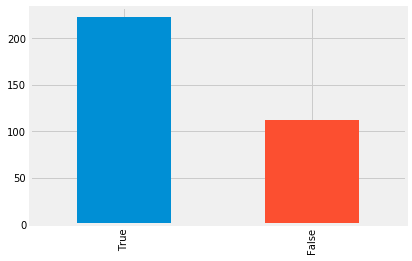

In [8]:
def check_if_trip_is_complete(df):
    first_and_last = df.iloc[[0, -1]].stop_name
    if pd.isnull(first_and_last).any():
        return False
    else:
        return list(sorted(df.iloc[[0, -1]].stop_name)) == ['34 St - 11 Av', 'Flushing - Main St']

(trains.groupby('unique_trip_id')
 .apply(check_if_trip_is_complete)
 .value_counts().plot.bar())

Two thirds of the train trips included in this dataset are complete&mdash;e.g. they record all of the stops the train took, from the first stop all the way to the last. The remaining one-third of stops are incomplete; they record trips that have been split into two or more segments.

A schedule getting scrubbed almost always means that the train is experiencing significant delays. By looking at what station the train was sitting in or going to right before the schedule was scrubbed, we can see which stops trains tended to get delayed at.

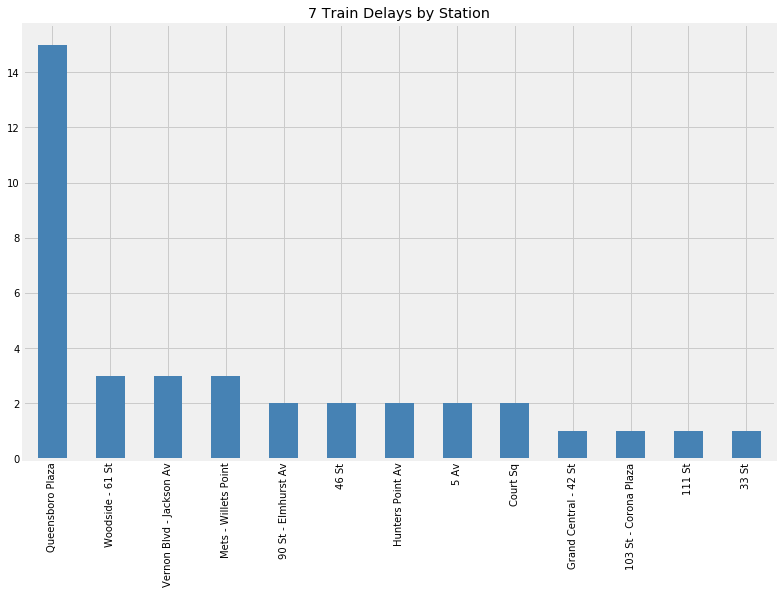

In [9]:
def get_problematic_station(df):
    first_and_last = df.iloc[[0, -1]].stop_name
    if pd.isnull(first_and_last).any():
        return None
    elif not list(sorted(df.iloc[[0, -1]].stop_name)) == ['34 St - 11 Av', 'Flushing - Main St']:
        last_station = df.iloc[-1].stop_name
        if last_station == 'Flushing - Main St' or last_station == '34 St - 11 Av':
            return None
        else:
            return df.iloc[-1].stop_name

(trains.groupby('unique_trip_id')
 .apply(get_problematic_station)
 .value_counts().plot.bar(color='steelblue', figsize=(12, 8), title='7 Train Delays by Station'))

It looks like many of the delays that day occurred near Queensbororo Plaza.

The Ibry chart is a structured visualization of train stops across time and station that was famously applied to Paris-Lyon train line in France, and which later appeared on the cover of Edward Tufte's seminal book on data visualization, "The Visual Display of Quantitative Information". The code that follows builds two such charts for our 7 train data&mdash;one for northbound (Flushing to Hudson Yards) trips, and one for southbound (Hudson Yard to Flushing) trips.

In [10]:
sns.set_style('white')

stop_sequence = [
 'Flushing - Main St',
 'Mets - Willets Point',
 '111 St',
 '103 St - Corona Plaza',
 'Junction Blvd',
 '90 St - Elmhurst Av',
 '82 St - Jackson Hts',
 '74 St - Broadway',
 '69 St',
 'Woodside - 61 St',
 '52 St',
 '46 St',
 '40 St',
 '33 St',
 'Queensboro Plaza',
 'Court Sq',
 'Hunters Point Av',
 'Vernon Blvd - Jackson Av',
 'Grand Central - 42 St',
 '5 Av',
 'Times Sq - 42 St',
 '34 St - 11 Av'
]

def plot_trains(trains, title):
    estimated_times = []
    for min_timestamp, max_timestamp in zip(trains.minimum_time, trains.maximum_time):
        estimated_times.append(
            min_timestamp + (max_timestamp - min_timestamp) / 2
        )

    timetable = pd.pivot_table(
        trains.assign(estimated_arrival_time=estimated_times),
        index='unique_trip_id',
        columns='stop_name',
        values='minimum_time'
    ).T.reindex(stop_sequence)

    ax = timetable.rename_axis(None).plot.line(legend=False, color='black', linewidth=1, figsize=(16, 24))
    ax.axvline(0, color='black', linewidth=1)
    ax.axvline(21, color='black', linewidth=1)
    plt.xticks([0 , 22], [stop_sequence[0], stop_sequence[21]], fontsize=16)
    plt.yticks([], [])
    plt.title(title, fontsize=16)
    sns.despine(left=True, bottom=True)

Time on the left axis, and stop number on the bottom:

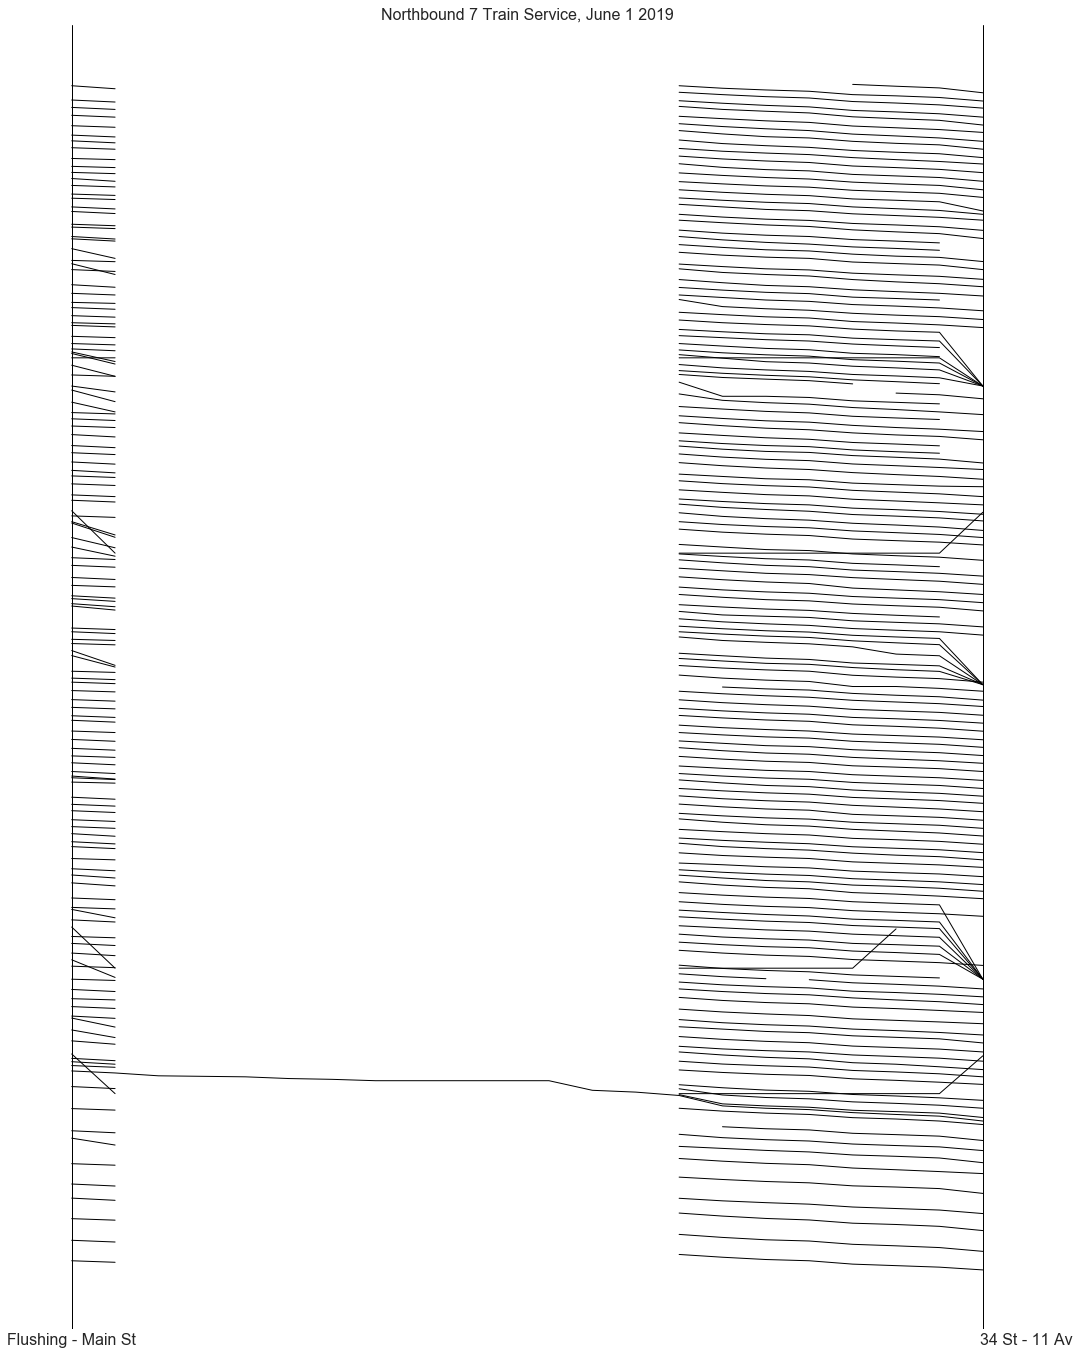

In [11]:
northbound_trains = trains[trains.stop_id.map(lambda v: 'N' in v)]
plot_trains(northbound_trains, 'Northbound 7 Train Service, June 1 2019')

All but one of the northbound 7 trains ran express that day! This explains why there were so many trips that were 12 stops in length, but which had the local service `7` headsign instead of the express service `7X` headsign.

Most trips are neatly sequential, as you would expect. Service looked very smooth that day overall; there were some delays, demarkated by increasing slopes in the lines, but the trains were mostly able to maintain a consistent headway (time between train arrivals) throughout the day. We can also see how there were far fewer trains running in the early morning hours e.g. between midnight and around 7 AM, then there were later in the day. The number of trains was otherwise pretty consistent across all times.

We can see some data and library artifacts in this plot:

* Trains seem to cross over one another going into the last stop in the line, Flushing - Main Street. This occurs because trains are staying in the data stream after arriving at the last stop, which throws off the accuracy of our naive estimate (which is just `minimum_time + (maximum_time - minimum_time) / 2`).
* Some trains seem to jump back in time on arrival to their final station; this is a data error that I'm still investigating.
* Some train trips are discontiguous, indicating places where the service schedule got scrubbed and rebuilt.
* Trains are sometimes added to the feed one-at-a-time, sometimes in groups. Some of the trains were added to the feed seconds before they set off, causing us to miss their first stop, 34 St - 11 Av, completely.

If we look at southbound 7 train service, we see a different picture:

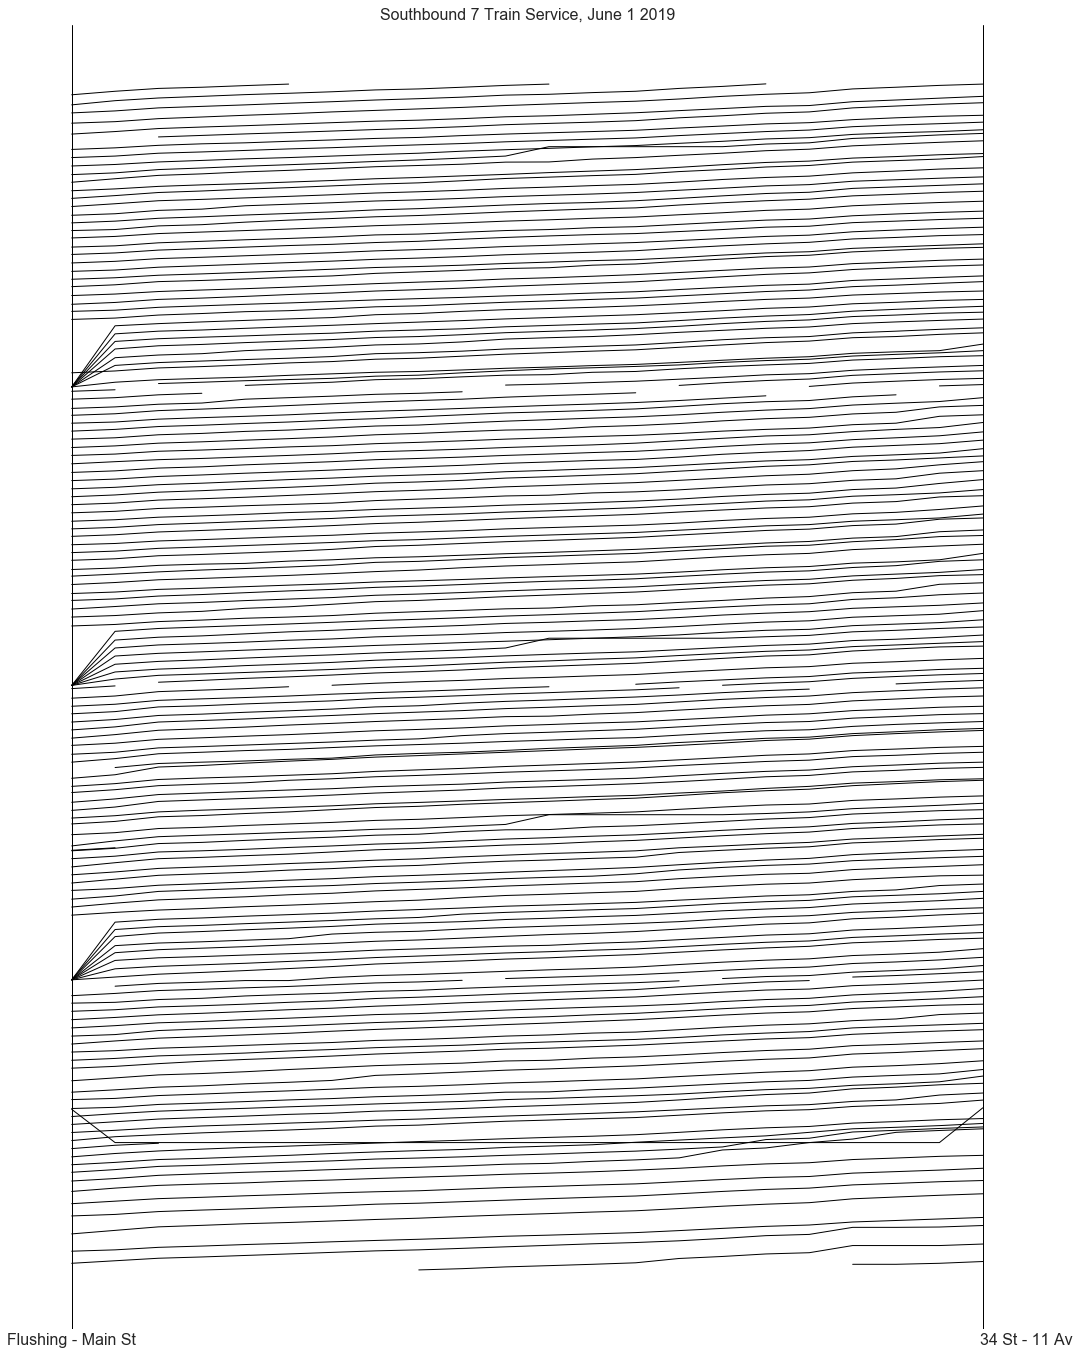

In [12]:
southbound_trains = trains[trains.stop_id.map(lambda v: 'S' in v)]
plot_trains(southbound_trains, 'Southbound 7 Train Service, June 1 2019')

In contrast to the northbound 7 trains, all of the southbound 7 trains that day made all local stops. This makes sense, as it would impossible otherwise to access any of the stations that the northbound trains skipped.

The Flushing - Main Street dispatch, like the 34 St - 11 Av dispatch, sometimes adds multiple trains at once to the feed. They also add trains seconds before they leave the station, but seem to do so more rarely than the 34 St - 11 Av dispatch does.

For the most part, we see the same smooth headway pattern we saw with the northbound trains, indicating that this was a pretty good service day for the southbound 7 trains as well.

That concludes this short demo. For more example applications of this data stream, see the section [Further reading](https://residentmario.github.io/gtfs-tripify/further_reading.html). To learn how to roll a dataset like this yourself, see the [Tutorial](https://residentmario.github.io/gtfs-tripify/tutorial.html) section.